# R Exercises - part 6
- Name: Alberto Coppi
- Student ID: 2053063
- E-mail: <alberto.coppi@studenti.unipd.it>

## Import useful libraries

In [1]:
library(ggplot2)
library(gridExtra)
library(tidyverse)
library(coda)
library(rstan)
library(rjags)
library(dplyr)
library(Rlab)

Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”
── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1
✔ purrr   0.3.4     

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::combine() masks gridExtra::combine()
✖ dplyr::filter()  masks stats::filter()
✖ dplyr::lag()     masks stats::lag()

Loading required package: StanHeaders

rstan (Version 2.21.5, GitRev: 2e1f913d3ca3)

For execution on a local, multicore CPU with excess RAM we recommend calling
options(mc.cores = parallel::detectCores()).
To avoid recompilation of unchanged Stan programs, we recommend calling
rstan_options(auto_write = TRUE)


Attaching package: ‘rstan’


The following object is masked from ‘package:coda’:

    traceplot


The following object is masked from ‘package:tidyr’:

    extract



## Ex1 - New method of screeening
### a) 
The probability distribution of $y$ is $Binom(n, p)$ where $n$ is the number of patients and $p$ is the probability the new method fails.

### b)
In the frequentist approach the unbiased estimator of the failure probability is $\frac{y}{n}=\frac{6}{75}=0.08$

### c)
Assuming a beta prior in our bayesian approach we obtain a beta posterior with parameters:  
$
    \alpha_{post} = \alpha_{pre} + y\\
    \beta_{post} = \alpha_{pre} + n - y\\
    \alpha_{pre} = \frac{m\beta_{pre}}{1-m}\\
    \beta_{pre} = \frac{m(m-1)^2}{s^2} + m - 1\\
$

where $m$ and $s$ are the mean and standard deviation of the prior distribution.
I chose to plot the standard deviation instead of variance to make the plot more readable.

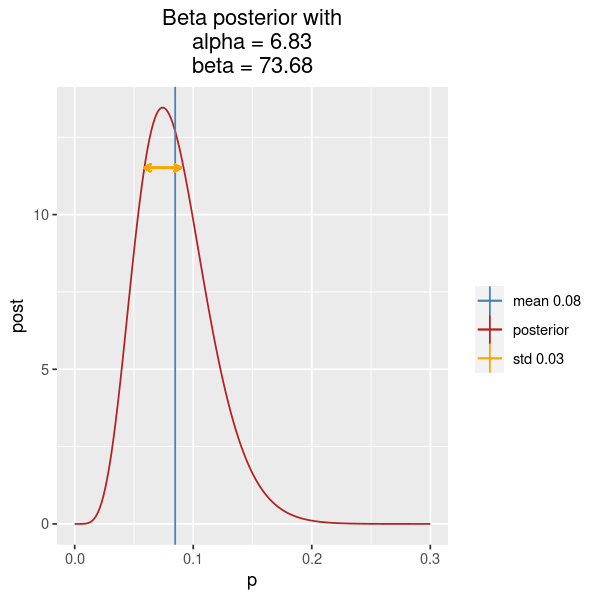

In [2]:
mean <- 0.15
std  <- 0.14
n    <- 75
y    <- 6

beta.pre   <- mean*(mean-1)^2/std^2 + mean - 1
alpha.pre  <- mean*beta.pre/(1-mean)
alpha.post <- alpha.pre + y
beta.post  <- beta.pre + n - y
mean.post  <- alpha.post/(alpha.post+beta.post)
mode.post  <- (alpha.post-1) / (alpha.post + beta.post - 2)
std.post   <- sqrt(alpha.post*beta.post/((alpha.post+beta.post)^2*(alpha.post+beta.post+1)))

posterior <- function(p) {dbeta(p, alpha.post, beta.post)}

# plot
options(repr.plot.height=5, repr.plot.width=5)
legend <- c(sprintf('mean %.2f', mean.post), 'posterior', sprintf('std %.2f', std.post))
scale_colour <- c('steelblue', 'firebrick', 'orange')
names(scale_colour) <- legend

p <- seq(0, 0.3, length.out=201)
ggplot(data.frame(p=p, post=posterior(p)), aes(x=p, y=post)) +
geom_path(aes(colour='posterior')) +
geom_vline(aes(xintercept=mean.post, colour = legend[[1]])) +
geom_segment(aes(x=mode.post-std.post/2, y=posterior(mode.post-std.post/2), 
                 xend=mode.post+std.post/2, yend=posterior(mode.post-std.post/2), 
                 colour=legend[[3]]), arrow=arrow(ends='both', length = unit(0.02, "npc"))) +
scale_colour_manual(name='', values=scale_colour) +
labs(title=sprintf('Beta posterior with\nalpha = %.2f\nbeta = %.2f', alpha.post, beta.post),
     colour='Type', legend.position='right') + 
theme(plot.title=element_text(hjust=0.5), )

In [3]:
alpha.pre_ex1 <- alpha.pre
beta.pre_ex1  <- beta.pre

### d) and e)

In [4]:
alpha <- 0.05
p <- 0.15

test <- integrate(posterior, lower=p, upper=1)[[1]]
cat("Bayesian approach:\nThe new method is", 
    ifelse(test<alpha, " ", " no "), 
    "better than the traditional method ",
    sprintf("(test=%.3f)", test),
    "\n", sep='')

h0 <- function(y) {pbinom(y, size=n, prob=p)}

pvalue <- h0(y)
cat("\nFrequentist approach:\nThe new method is", 
    ifelse(pvalue<alpha, " ", " no "), 
    "better than the traditional method ",
    sprintf("(pvalue=%.3f)", pvalue),
    "\n", sep='')

Bayesian approach:
The new method is better than the traditional method (test=0.031)

Frequentist approach:
The new method is no better than the traditional method (pvalue=0.054)


## Ex2 - Deaths by horse kick

In [5]:
data2 <- data.frame(y=c(0, 1, 2, 3, 4, 5),
                    n1=c(109, 65, 22, 3, 1, 0),
                    n2=c(144, 91, 32, 11, 2, 0))

### a)

n1 observations:
 	mean:	0.615
	median:	0.613
	var:	0.003
	95% ci:	0.511 - 0.728 

n2 observations:
 	mean:	0.704
	median:	0.702
	var:	0.003
	95% ci:	0.609 - 0.805 



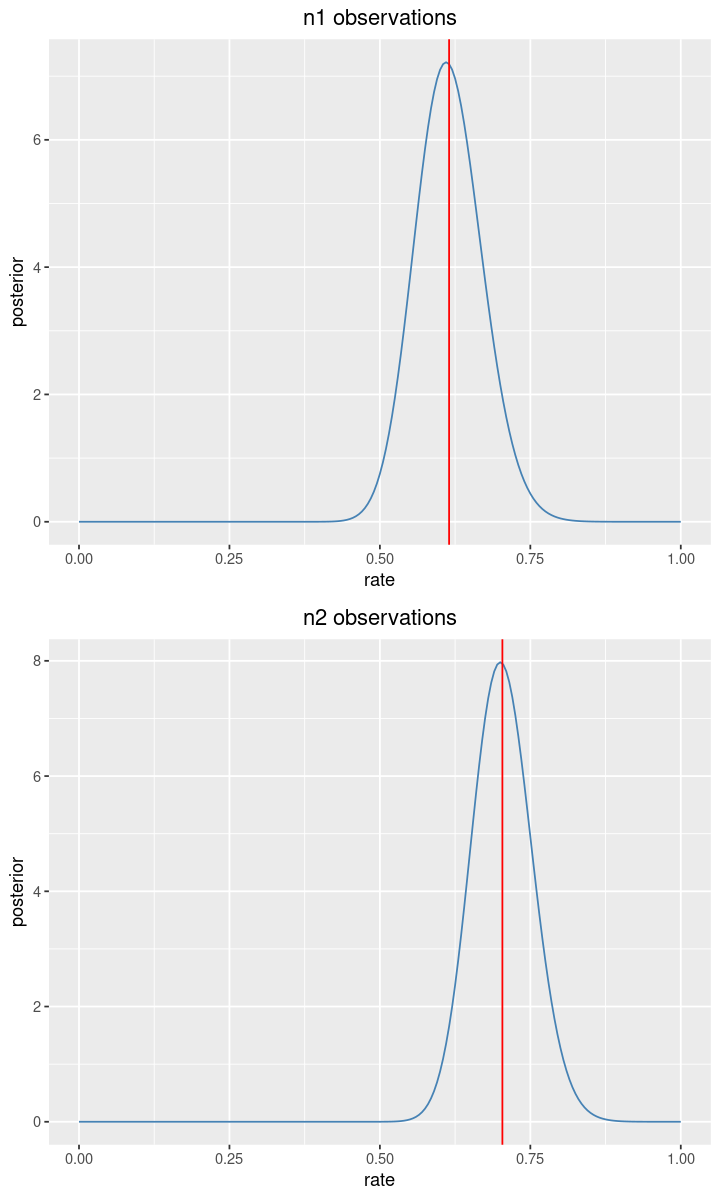

In [6]:
cl <- 0.95
plts <- list()
rate <- seq(0, 1, length.out=201)

for( i in 1:2) {
    alpha.prior  <- 1
    lambda.prior <- 0

    alpha.post  <- alpha.prior + sum(data2['y']*data2[paste('n', i, sep='')])
    lambda.post <- lambda.prior + sum(data2[paste('n', i, sep='')])

    posterior <- function(rate) {dgamma(rate, alpha.post, lambda.post)}

    # calculate quantities of interest
    mean   <- alpha.post / lambda.post
    var    <- mean / lambda.post
    median <- qgamma(0.5, alpha.post, lambda.post)
    ci     <- c(qgamma((1-cl)/2, alpha.post, lambda.post),
                qgamma((1+cl)/2, alpha.post, lambda.post))

    cat(paste('n', i, sep=''), 'observations:\n', 
        sprintf('\tmean:\t%.3f\n\tmedian:\t%.3f\n\tvar:\t%.3f\n\t%i%% ci:\t%.3f - %.3f',
                mean, median, var, cl*100,ci[1], ci[2]), '\n\n')
    
    # plot (ggplot is fun and i can't figure out why it goes crazy with the commented lines and if xintercept is inside aes mapping)
    #legend <- c('pdf', sprintf('mean %.3f', mean))
    #scale_colors <- c('steelblue', 'firebrick')
    #names(scale_colors) <- legend

    plts[[i]] <- ggplot(data.frame(rate=rate, posterior=posterior(rate)), aes(x=rate, y=posterior)) +
                 geom_path(color='steelblue') +
                 geom_vline(xintercept=mean, color='red') +
                 labs(title=paste('n', i, ' observations', sep='')) +
                 theme(plot.title=element_text(hjust=0.5))
                 #scale_colour_manual(name='', values=scale_colors) +
}

options(repr.plot.width=6, repr.plot.height=10)
grid.arrange(grobs=plts, ncols=1)


### b)

n1 observations:
 	mean:	0.613
	median:	0.611
	var:	0.003
	95% ci:	0.509 - 0.726 

n2 observations:
 	mean:	0.702
	median:	0.701
	var:	0.003
	95% ci:	0.607 - 0.803 



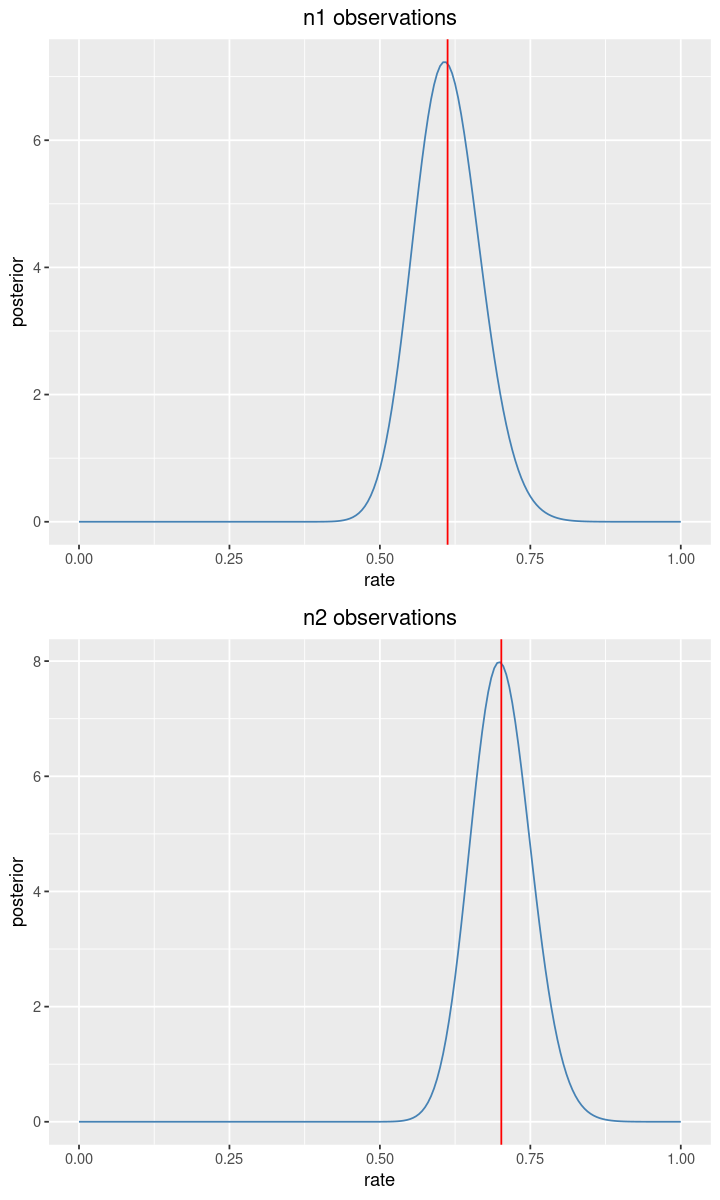

In [7]:
cl <- 0.95
plts <- list()
rate <- seq(0, 1, length.out=201)

for( i in 1:2) {
    alpha.prior  <- 1/2
    lambda.prior <- 0

    alpha.post  <- alpha.prior + sum(data2['y']*data2[paste('n', i, sep='')])
    lambda.post <- lambda.prior + sum(data2[paste('n', i, sep='')])

    posterior <- function(rate) {dgamma(rate, alpha.post, lambda.post)}

    # calculate quantities of interest
    mean   <- alpha.post / lambda.post
    var    <- mean / lambda.post
    median <- qgamma(0.5, alpha.post, lambda.post)
    ci     <- c(qgamma((1-cl)/2, alpha.post, lambda.post),
                qgamma((1+cl)/2, alpha.post, lambda.post))

    cat(paste('n', i, sep=''), 'observations:\n', 
        sprintf('\tmean:\t%.3f\n\tmedian:\t%.3f\n\tvar:\t%.3f\n\t%i%% ci:\t%.3f - %.3f',
                mean, median, var, cl*100, ci[1], ci[2]), '\n\n')
    
    # plot (ggplot is fun and i can't figure out why it goes crazy with the commented lines and if xintercept is inside aes mapping)
    #legend <- c('pdf', sprintf('mean %.3f', mean))
    #scale_colors <- c('steelblue', 'firebrick')
    #names(scale_colors) <- legend

    plts[[i]] <- ggplot(data.frame(rate=rate, posterior=posterior(rate)), aes(x=rate, y=posterior)) +
                 geom_path(color='steelblue') +
                 geom_vline(xintercept=mean, color='red') +
                 labs(title=paste('n', i, ' observations', sep='')) +
                 theme(plot.title=element_text(hjust=0.5))
                 #scale_colour_manual(name='', values=scale_colors) +
}

options(repr.plot.width=6, repr.plot.height=10)
grid.arrange(grobs=plts, ncol=1)

## Ex3 - Water quality
### a)
The frequentist estimator of $p$ is simply $\hat p=\frac{y}{n}=\frac{11}{116}\simeq 0.095$

### b)

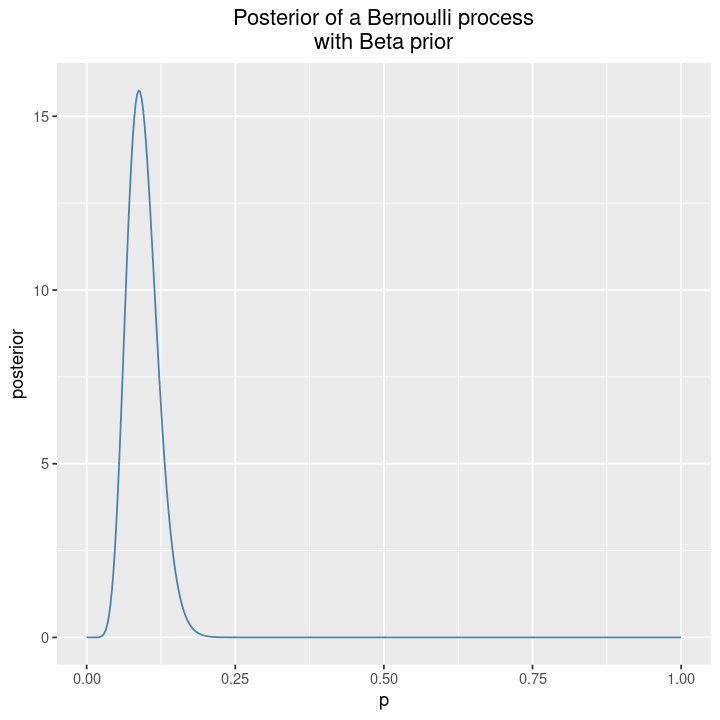

In [8]:
n1 <- 116
y1 <- 11

alpha.prior <- 1
beta.prior  <- 10
alpha.post1  <- alpha.prior + y1
beta.post1   <- beta.prior + n1 - y1

posterior1 <- function(p) {dbeta(p, alpha.post1, beta.post1)}

p=seq(0, 1, length.out=401)
options(repr.plot.width=6, repr.plot.height=6)
ggplot(data.frame(p=p, posterior=posterior1(p)), aes(x=p, y=posterior)) +
geom_path(color='steelblue') +
labs(title='Posterior of a Bernoulli process\nwith Beta prior') +
theme(plot.title=element_text(hjust=0.5))

### c)
The Bayesian estimator is the mode of the posterior distribution. Below the mode is calculated both using a numerical algorith and the theoretical value.

In [9]:
cl <- 0.95

p.bayes <- optimize(posterior1, c(0, 1), maximum=TRUE)[[1]]
mean    <- alpha.post1 / (alpha.post1 + beta.post1)
var     <- alpha.post1 * beta.post1 / ((alpha.post1 + beta.post1)^2*(alpha.post1 + beta.post1 + 1))
mode    <- (alpha.post1 - 1) / (alpha.post1 + beta.post1 - 2)
ci      <- c(qbeta((1-cl)/2, alpha.post1, beta.post1),
             qbeta((1+cl)/2, alpha.post1, beta.post1))

cat('Probability of high bacter level:\n', 
    sprintf('\tmode num\t: %.4f\n\tmode th\t\t: %.4f\n\tmean\t\t: %.4f\n\tvar\t\t: %.4f\n\t%i%% ci\t\t: %.4f - %.4f',
            p.bayes, mode, mean, var, cl*100, ci[1], ci[2]), 
    '\n')

Probability of high bacter level:
 	mode num	: 0.0880
	mode th		: 0.0880
	mean		: 0.0945
	var		: 0.0007
	95% ci		: 0.0502 - 0.1508 


### d)

In [10]:
alpha <- 0.05
p0    <- 0.1
mode  <- p0*(n1+1)

#frequentist
distance <- abs(y1-mode)
pvalue <- pbinom(ifelse(mode > distance, mode-distance, 0), size=n1, prob=p0) + pbinom(mode+distance, size=n1, prob=p0, lower.tail=FALSE)
cat("\nFrequentist approach:\n\tWe can", 
    ifelse(pvalue<alpha, " ", "'t "), 
    "reject the null hypothesis ",
    sprintf("(pvalue=%.3f)", pvalue), 
    "\n", sep='')

#Bayesian
test <- !between(p0, ci[[1]], ci[[2]])
cat("\nBayesian approach:\n\tWe can", 
    ifelse(test, " ", "'t "), 
    "reject the null hypothesis ", 
    "\n", sep='')


Frequentist approach:
	We can't reject the null hypothesis (pvalue=0.880)

Bayesian approach:
	We can't reject the null hypothesis 


### e)
The frequentist estimator for this dataset only would be $\hat p=\frac{y_2}{n_2}\simeq 0.055$. If we combine this information with the previous one we would get $\hat p\simeq 0.075$.

### f)

Bayesian estimator assuming:
	Beta(1,10)	: 0.052
	Prev. post.	: 0.069

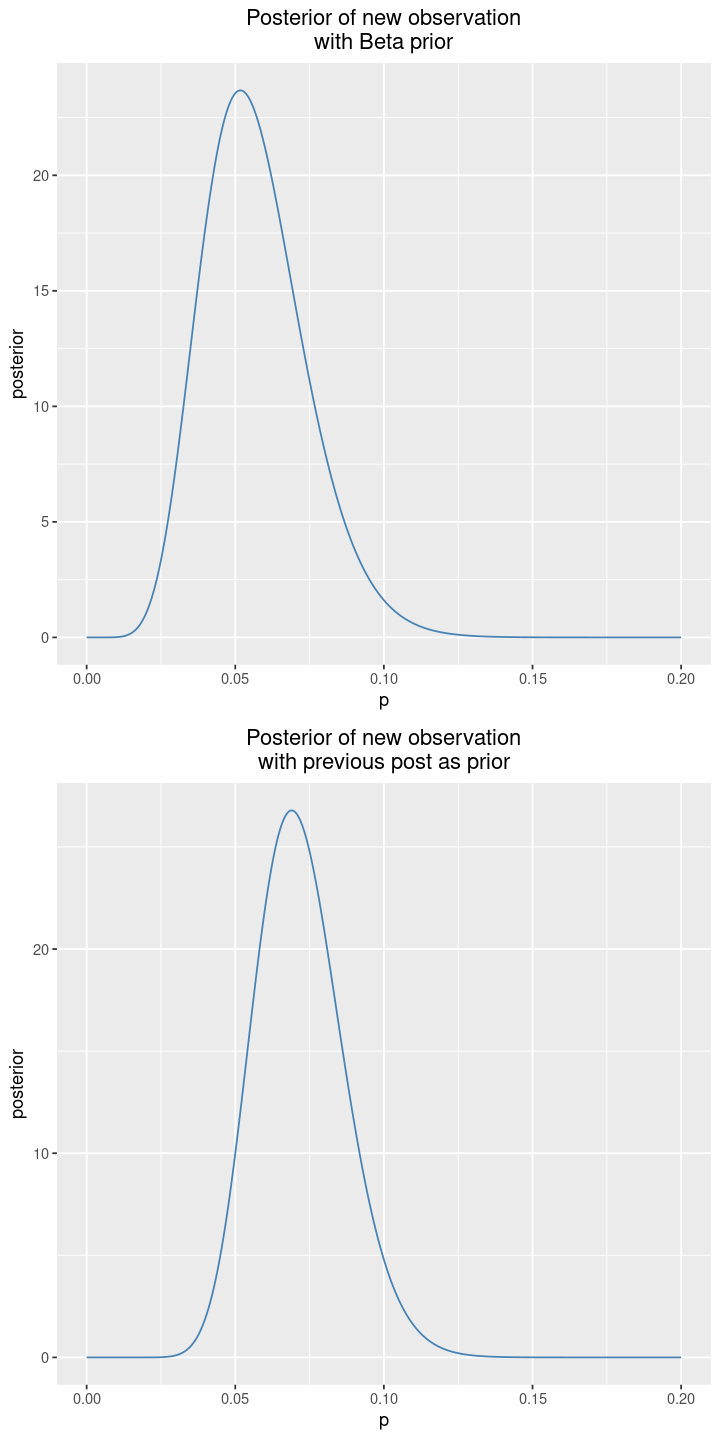

In [11]:
n2 <- 165
y2 <- 9

alpha.post2a  <- alpha.prior + y2
beta.post2a   <- beta.prior + n2 - y2

alpha.post2b <- alpha.post1 + y2
beta.post2b  <- beta.post1 + n2 - y2

posterior2a <- function(p) {dbeta(p, alpha.post2a, beta.post2a)}
posterior2b <- function(p) {dbeta(p, alpha.post2b, beta.post2b)}

p=seq(0, 0.20, length.out=401)
options(repr.plot.width=6, repr.plot.height=12)
plta <- ggplot(data.frame(p=p, posterior=posterior2a(p)), aes(x=p, y=posterior)) +
        geom_path(color='steelblue') +
        labs(title='Posterior of new observation\nwith Beta prior') +
        theme(plot.title=element_text(hjust=0.5))

pltb <- ggplot(data.frame(p=p, posterior=posterior2b(p)), aes(x=p, y=posterior)) +
        geom_path(color='steelblue') +
        labs(title='Posterior of new observation\nwith previous post as prior') +
        theme(plot.title=element_text(hjust=0.5))

grid.arrange(plta, pltb, ncol=1)
modea <- (alpha.post2a - 1) / (alpha.post2a+ beta.post2a - 2)
modeb <- (alpha.post2b - 1) / (alpha.post2b+ beta.post2b - 2)
cat(sprintf("Bayesian estimator assuming:\n\tBeta(1,10)\t: %.3f\n\tPrev. post.\t: %.3f", modea, modeb))

### g)
The Bayesian estimator has been provided in the previous point. Below the remaining requests.

In [12]:
cl <- 0.95

meana    <- alpha.post2a / (alpha.post2a + beta.post2a)
vara     <- alpha.post2a * beta.post2a / ((alpha.post2a + beta.post2a)^2*(alpha.post2a + beta.post2a + 1))
cia      <- c(qbeta((1-cl)/2, alpha.post2a, beta.post2a),
             qbeta((1+cl)/2, alpha.post2a, beta.post2a))

meanb    <- alpha.post2b / (alpha.post2b + beta.post2b)
varb     <- alpha.post2b * beta.post2b / ((alpha.post2b + beta.post2b)^2*(alpha.post2b + beta.post2b + 1))
cib      <- c(qbeta((1-cl)/2, alpha.post2b, beta.post2b),
             qbeta((1+cl)/2, alpha.post2b, beta.post2b))

cat('With Beta(1,10) prior:\n',
    sprintf('\tmean\t\t: %.4f\n\tvar\t\t: %.4f\n\t%i%% ci\t\t: %.4f - %.4f',
            meana, vara, cl*100, cia[1], cia[2]), 
    '\n\n', 
    'With previous posterior as prior:\n',
    sprintf('\tmean\t\t: %.4f\n\tvar\t\t: %.4f\n\t%i%% ci\t\t: %.4f - %.4f',
            meanb, varb, cl*100, cib[1], cib[2]), 
    sep='')

With Beta(1,10) prior:
	mean		: 0.0568
	var		: 0.0003
	95% ci		: 0.0277 - 0.0954

With previous posterior as prior:
	mean		: 0.0719
	var		: 0.0002
	95% ci		: 0.0452 - 0.1042

### h)
In testing with the frequentist approach I consider only the second dataset

In [13]:
alpha <- 0.05
p0    <- 0.1
mode  <- p0*(n2+1)
cat('At', alpha*100, '% level of significance')

#frequentist
distance <- abs(y2-mode)
pvalue <- pbinom(ifelse(mode > distance, mode-distance, 0), size=n2, prob=p0) + pbinom(mode+distance, size=n2, prob=p0, lower.tail=FALSE)
cat("\nFrequentist approach:\n\tWe can", 
    ifelse(pvalue<alpha, " ", "'t "), 
    "reject the null hypothesis ",
    sprintf("(pvalue=%.3f)", pvalue), 
    "\n", sep='')

#Bayesian
testa <- !between(p0, cia[[1]], cia[[2]])               # valid only if previous c.i. is calculated over (1-alpha) cl
testb <- !between(p0, cib[[1]], cib[[2]])
cat("\nBayesian approach with Beta(1,10):\n\tWe can", 
    ifelse(testa, " ", "'t "), 
    "reject the null hypothesis ", 
    "\n",
    "\nBayesian approach with previous posterior as prior:\n\tWe can", 
    ifelse(testb, " ", "'t "), 
    "reject the null hypothesis ", 
    "\n", 
    sep='')

At 5 % level of significance
Frequentist approach:
	We can't reject the null hypothesis (pvalue=0.051)

Bayesian approach with Beta(1,10):
	We can reject the null hypothesis 

Bayesian approach with previous posterior as prior:
	We can't reject the null hypothesis 


## Ex4 - Ex1 with MCMC

In [14]:
#generate data
isright <- FALSE

while(!isright) {
    data_sim <- rbern(75, mode.post)
    isright <- (sum(data_sim) == y)
}
sum(data_sim)

[1] 6

In [15]:
#define model
data <- list()

data$X <- data_sim
data$alpha <- alpha.pre_ex1
data$beta  <- beta.pre_ex1
data$n_next <- 75

model <- 'ex4.bug'

jm <- jags.model(model, data)

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 75
   Unobserved stochastic nodes: 2
   Total graph size: 80

Initializing model



In [16]:
#burn-in and running
update(jm, 2000)

chain <- coda.samples(jm , c("p", "y"), n.iter=10000)

print(summary(chain))
chain.df <- as.data.frame(as.mcmc(chain))
bayes_density <- density(chain.df[['y']])

bayes_est <- bayes_density[['x']][which.max(bayes_density[['y']])]
cat(sprintf('Bayesian estimator for y: %.4f', bayes_est))


Iterations = 2001:12000
Thinning interval = 1 
Number of chains = 1 
Sample size per chain = 10000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

     Mean      SD  Naive SE Time-series SE
p 0.08512 0.03105 0.0003105      0.0003105
y 6.41010 3.38190 0.0338190      0.0338190

2. Quantiles for each variable:

     2.5%     25%     50%    75%   97.5%
p 0.03485 0.06235 0.08184 0.1038  0.1552
y 1.00000 4.00000 6.00000 8.0000 14.0000

Bayesian estimator for y: 5.0238

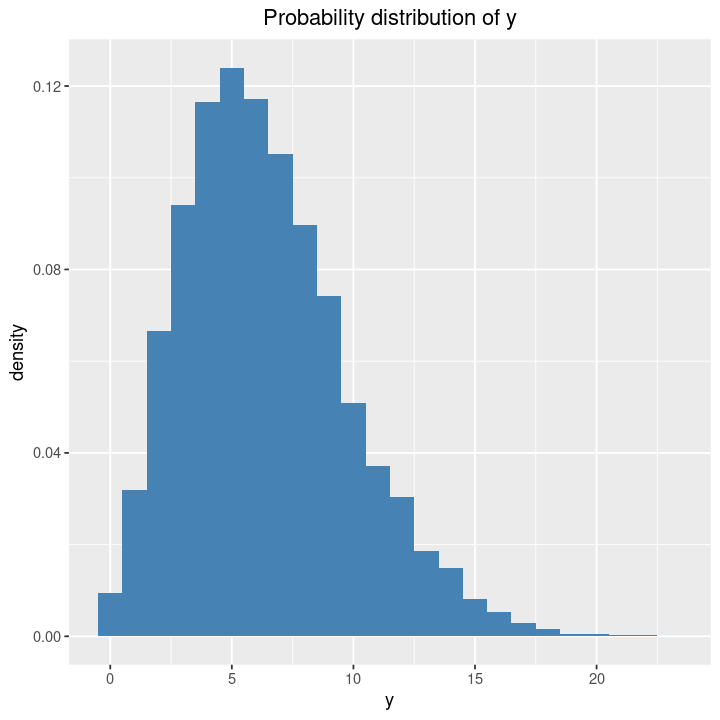

In [17]:

options(repr.plot.height=6, repr.plot.width=6)
ggplot(chain.df, aes(x=y, y=after_stat(density))) +
geom_histogram(fill='steelblue', binwidth=1) +
labs(title='Probability distribution of y', x='y') +
theme(plot.title=element_text(hjust=0.5))

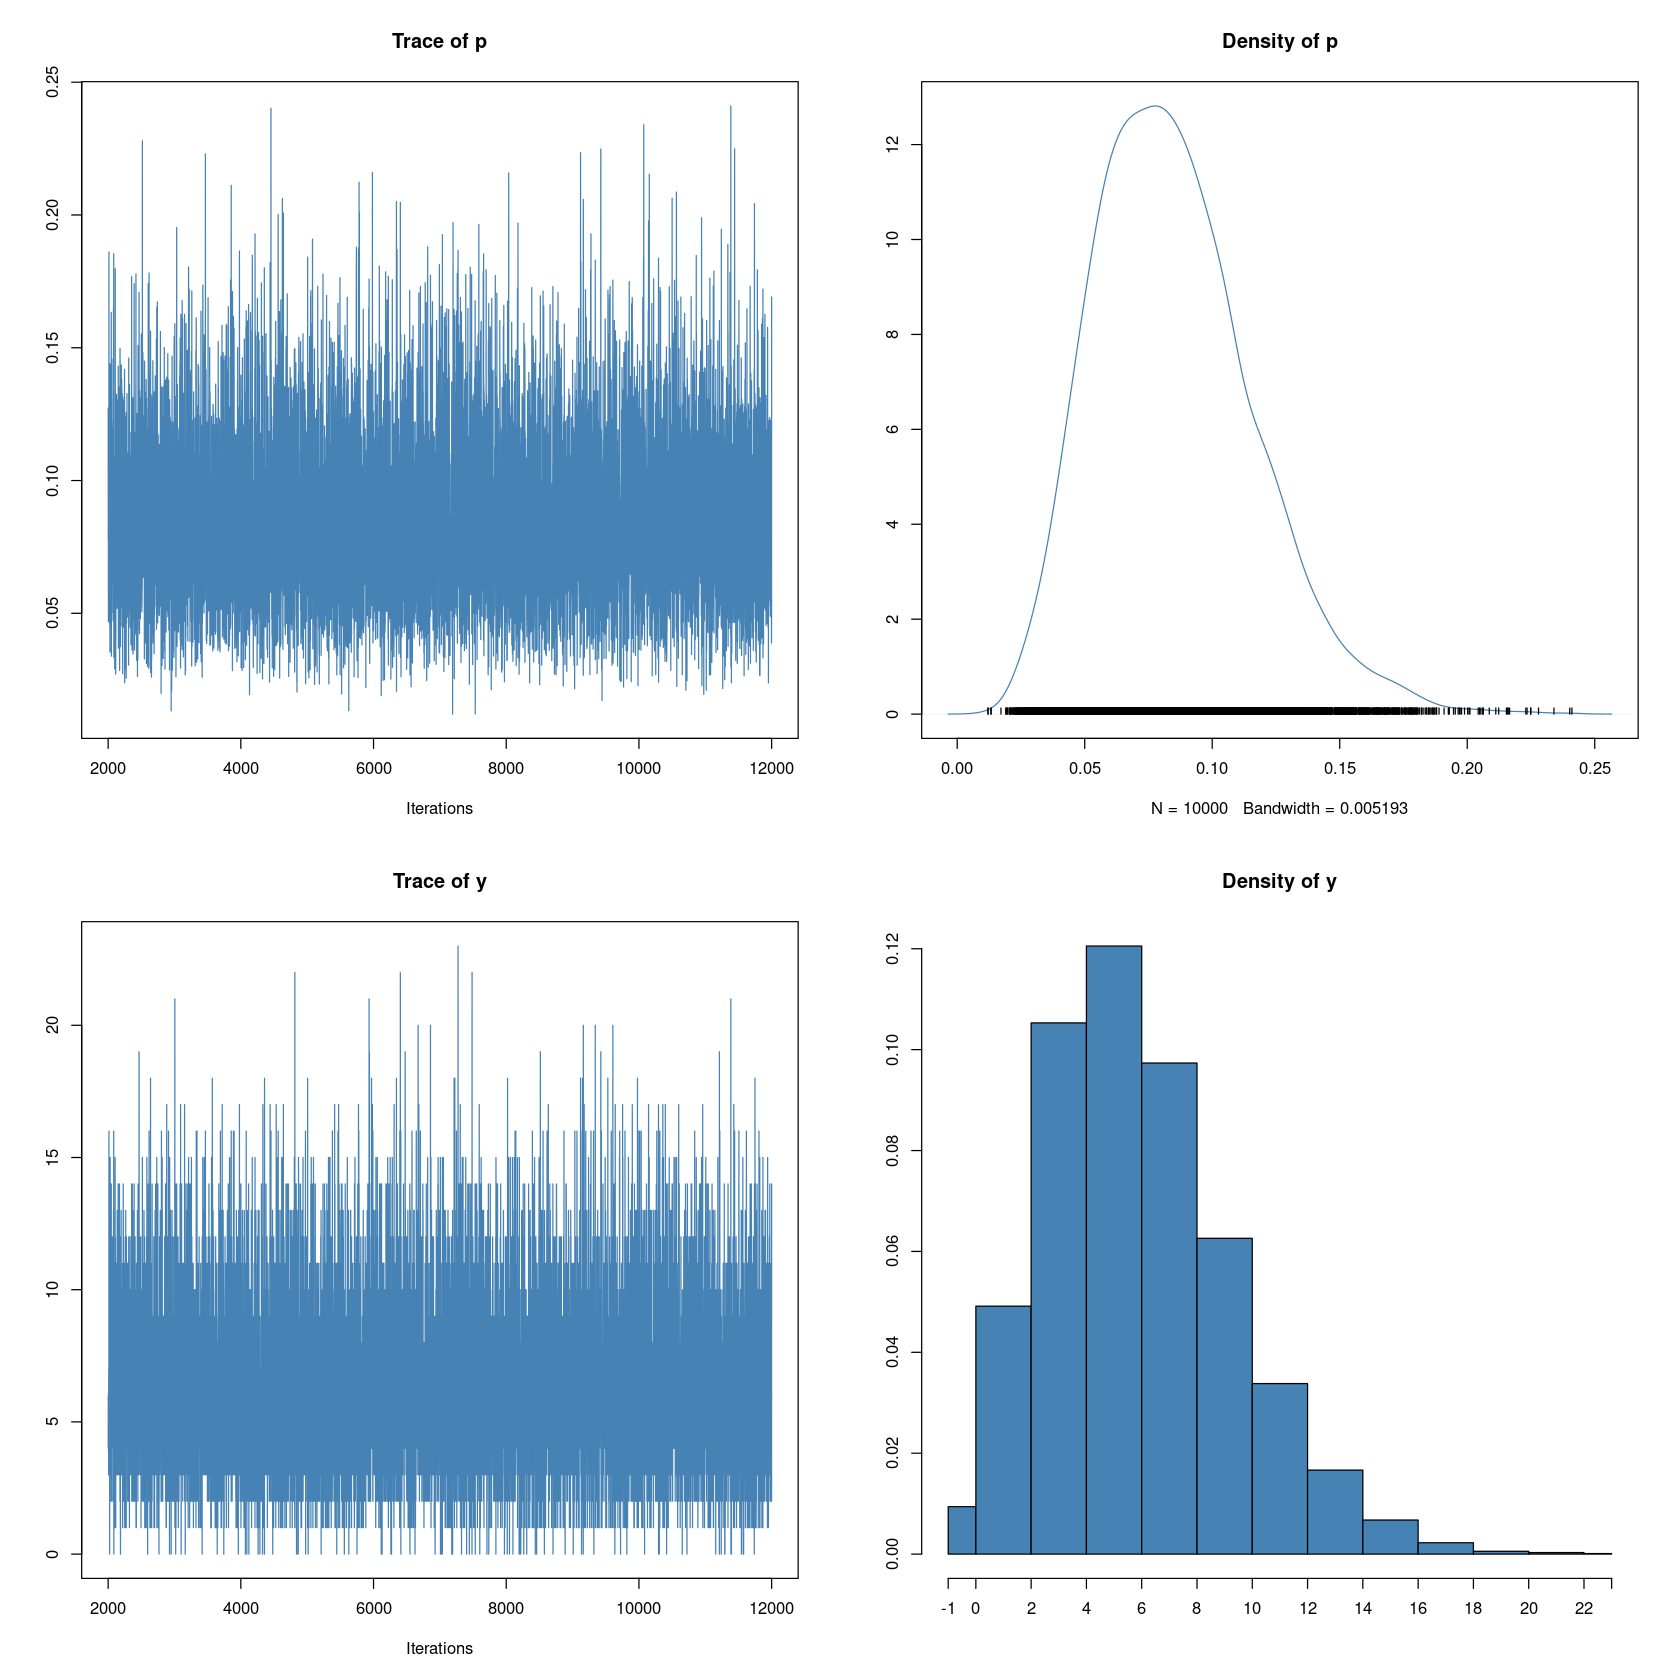

In [18]:
options(repr.plot.height=14, repr.plot.width=14)
plot(chain, col='steelblue')

## Ex5 - Ex2 with MCMC

### a) with uniform prior

In [19]:
#define model
data <- list()

data_sim1 <- rep(data2[['y']], data2[['n1']])
data_sim2 <- rep(data2[['y']], data2[['n2']])

data$X <- data_sim1
data$Y <- data_sim2
data$alpha <- 1
data$beta  <- 1         #uniform prior

model <- 'ex5.bug'

jm <- jags.model(model, data)

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 480
   Unobserved stochastic nodes: 2
   Total graph size: 484

Initializing model



In [20]:
#burn-in and running
update(jm, 2000)

chain <- coda.samples(jm , c("lambda1", "lambda2"), n.iter=10000)

#print mean, variance, credibility interval and mode
print(summary(chain))
chain.df <- as.data.frame(as.mcmc(chain))
bayes_density1 <- density(chain.df[['lambda1']])
bayes_density2 <- density(chain.df[['lambda2']])

bayes_est1 <- bayes_density1[['x']][which.max(bayes_density1[['y']])]
bayes_est2 <- bayes_density2[['x']][which.max(bayes_density2[['y']])]
cat(sprintf('Bayesian estimator:\n\tlambda1: %.4f\n\tlambda2: %.4f', bayes_est1, bayes_est2))


Iterations = 3001:13000
Thinning interval = 1 
Number of chains = 1 
Sample size per chain = 10000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

          Mean      SD  Naive SE Time-series SE
lambda1 0.6152 0.05596 0.0005596      0.0006898
lambda2 0.7033 0.05039 0.0005039      0.0006476

2. Quantiles for each variable:

          2.5%    25%    50%    75%  97.5%
lambda1 0.5130 0.5759 0.6128 0.6519 0.7324
lambda2 0.6091 0.6685 0.7022 0.7369 0.8062

Bayesian estimator:
	lambda1: 0.6080
	lambda2: 0.7018

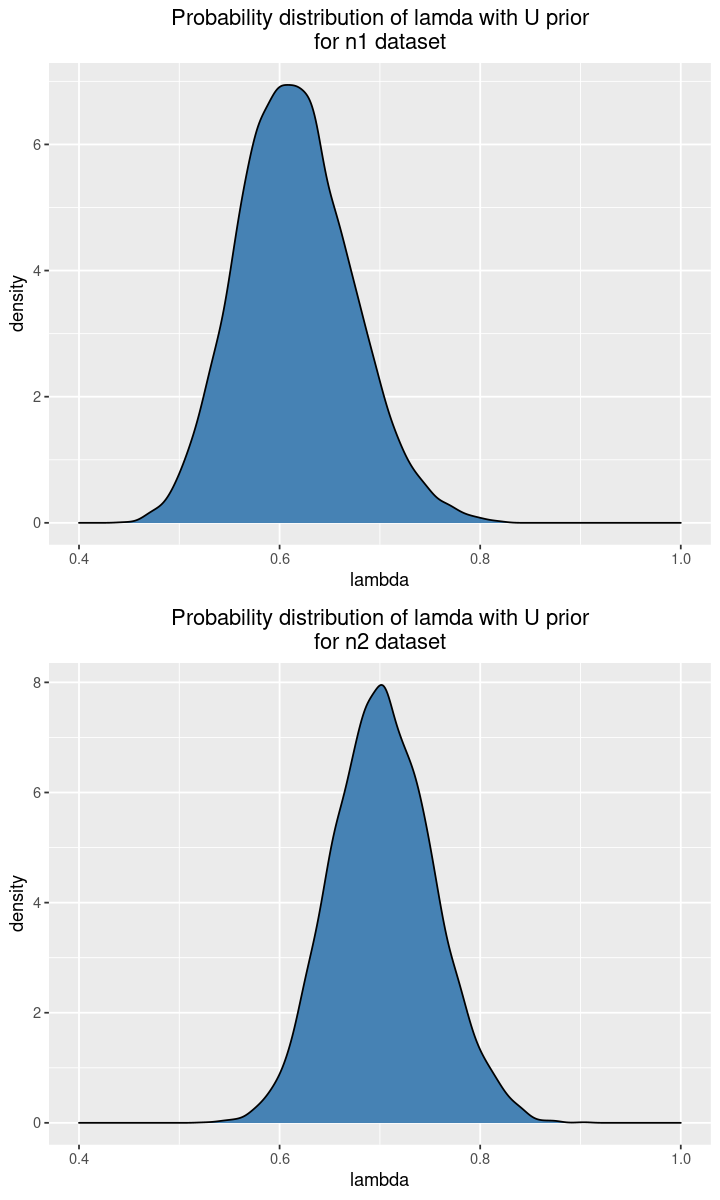

In [21]:

plt1 <- ggplot(chain.df, aes(x=lambda1, y=after_stat(density))) +
        geom_density(fill='steelblue') +
        labs(title='Probability distribution of lamda with U prior\nfor n1 dataset', x='lambda') +
        theme(plot.title=element_text(hjust=0.5)) +
        xlim(c(0.4, 1))
plt2 <- ggplot(chain.df, aes(x=lambda2)) +
        geom_density(fill='steelblue') +
        labs(title='Probability distribution of lamda with U prior\nfor n2 dataset', x='lambda') +
        theme(plot.title=element_text(hjust=0.5)) +
        xlim(c(0.4, 1))

options(repr.plot.width=6, repr.plot.height=10)
grid.arrange(plt1, plt2, ncol=1)

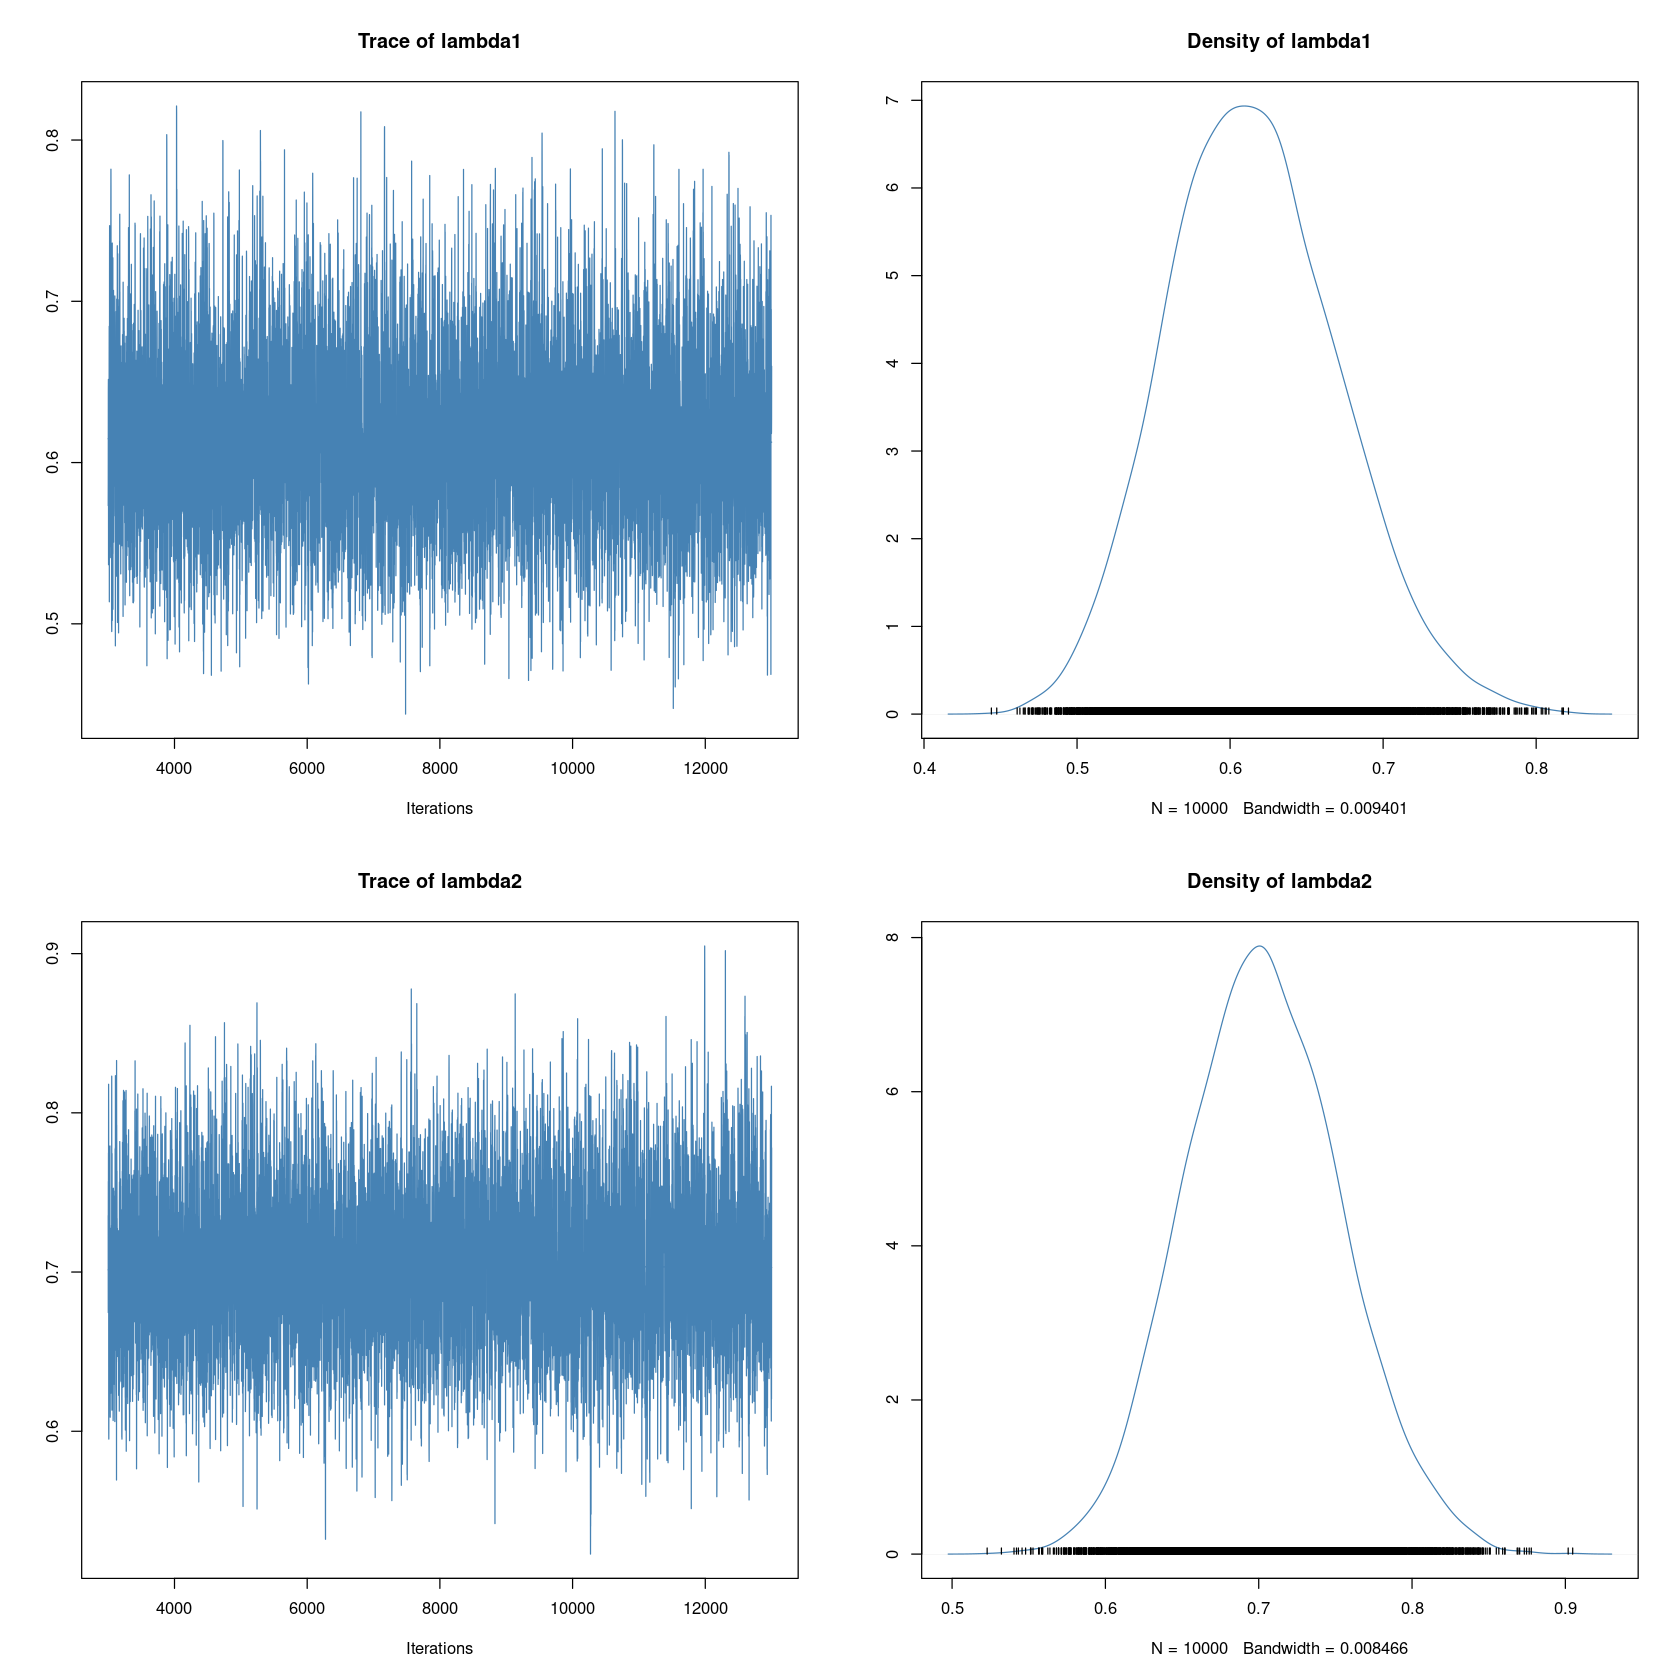

In [22]:
options(repr.plot.height=14, repr.plot.width=14)
plot(chain, col='steelblue')

### b) with Jeffrey's prior

In [23]:
#define model
data <- list()

data_sim1 <- rep(data2[['y']], data2[['n1']])
data_sim2 <- rep(data2[['y']], data2[['n2']])

data$X <- data_sim1
data$Y <- data_sim2
data$alpha <- 0.5
data$beta  <- 0.5         #jeffrey's prior

model <- 'ex5.bug'

jm <- jags.model(model, data)

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 480
   Unobserved stochastic nodes: 2
   Total graph size: 484

Initializing model



In [24]:
#burn-in and running
update(jm, 2000)

chain <- coda.samples(jm , c("lambda1", "lambda2"), n.iter=10000)

print(summary(chain))
chain.df <- as.data.frame(as.mcmc(chain))
bayes_density1 <- density(chain.df[['lambda1']])
bayes_density2 <- density(chain.df[['lambda2']])

bayes_est1 <- bayes_density1[['x']][which.max(bayes_density1[['y']])]
bayes_est2 <- bayes_density2[['x']][which.max(bayes_density2[['y']])]
cat(sprintf('Bayesian estimator:\n\tlambda1: %.4f\n\tlambda2: %.4f', bayes_est1, bayes_est2))


Iterations = 3001:13000
Thinning interval = 1 
Number of chains = 1 
Sample size per chain = 10000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

          Mean      SD  Naive SE Time-series SE
lambda1 0.6154 0.05628 0.0005628      0.0007182
lambda2 0.7057 0.05042 0.0005042      0.0006606

2. Quantiles for each variable:

          2.5%    25%    50%    75%  97.5%
lambda1 0.5091 0.5767 0.6136 0.6523 0.7298
lambda2 0.6106 0.6709 0.7047 0.7387 0.8080

Bayesian estimator:
	lambda1: 0.6015
	lambda2: 0.7042

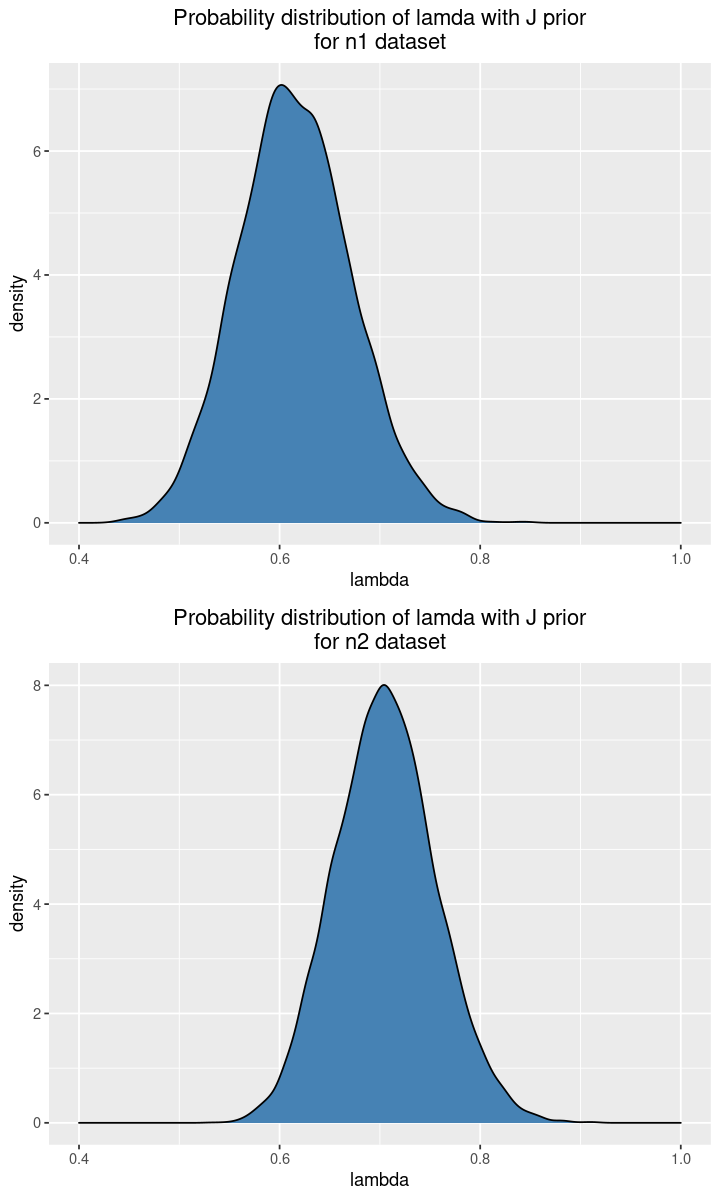

In [25]:

plt1 <- ggplot(chain.df, aes(x=lambda1, y=after_stat(density))) +
        geom_density(fill='steelblue') +
        labs(title='Probability distribution of lamda with J prior\nfor n1 dataset', x='lambda') +
        theme(plot.title=element_text(hjust=0.5)) +
        xlim(c(0.4, 1))
plt2 <- ggplot(chain.df, aes(x=lambda2)) +
        geom_density(fill='steelblue') +
        labs(title='Probability distribution of lamda with J prior\nfor n2 dataset', x='lambda') +
        theme(plot.title=element_text(hjust=0.5)) +
        xlim(c(0.4, 1))

options(repr.plot.width=6, repr.plot.height=10)
grid.arrange(plt1, plt2, ncol=1)

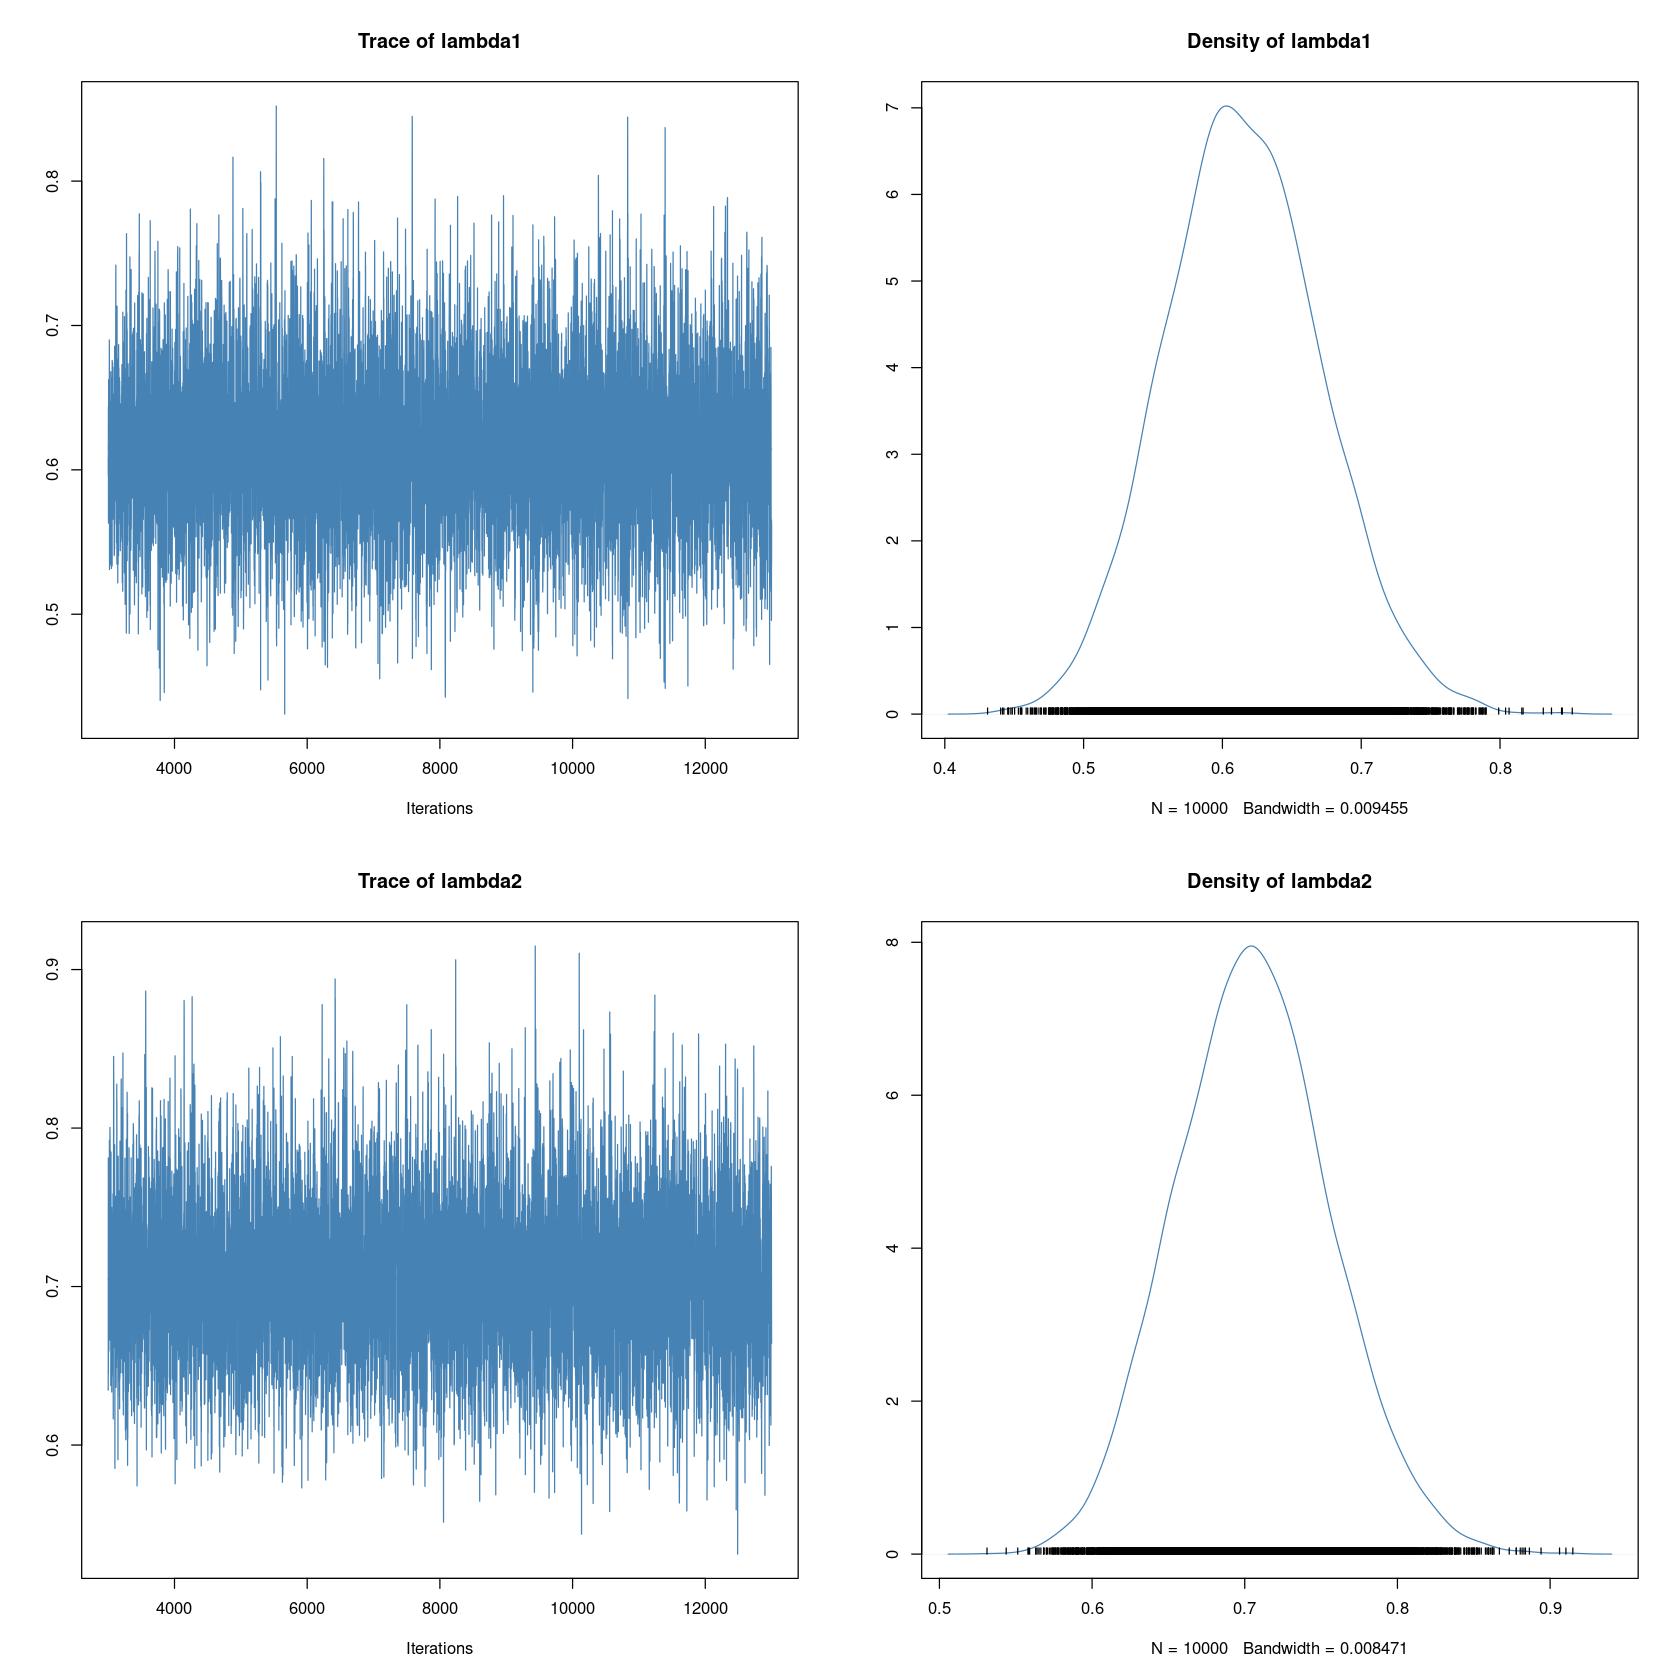

In [26]:
options(repr.plot.height=14, repr.plot.width=14)
plot(chain, col='steelblue')

## Ex6 - Ex3 with MCMC

In [27]:
#generate data
isright <- FALSE

while(!isright) {
    data_sim <- rbern(116, p.bayes)
    isright <- (sum(data_sim) == 11)
}
sum(data_sim)

[1] 11

In [28]:
#define model
data <- list()

data$X <- data_sim
data$n_next <- 116

model <- 'ex6.bug'

jm <- jags.model(model, data)

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 116
   Unobserved stochastic nodes: 2
   Total graph size: 121

Initializing model



In [29]:
#burn-in and running
update(jm, 2000)

chain <- coda.samples(jm , c("p", "y"), n.iter=10000)

print(summary(chain))
chain.df <- as.data.frame(as.mcmc(chain))
bayes_density <- density(chain.df[['p']])

bayes_est <- bayes_density[['x']][which.max(bayes_density[['y']])]
cat(sprintf('Bayesian estimator for p: %.4f', bayes_est))


Iterations = 2001:12000
Thinning interval = 1 
Number of chains = 1 
Sample size per chain = 10000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

      Mean      SD  Naive SE Time-series SE
p  0.09452 0.02583 0.0002583      0.0002583
y 10.93040 4.37587 0.0437587      0.0437587

2. Quantiles for each variable:

     2.5%     25%      50%     75%   97.5%
p 0.04988 0.07621  0.09239  0.1107  0.1505
y 4.00000 8.00000 11.00000 14.0000 21.0000

Bayesian estimator for p: 0.0866

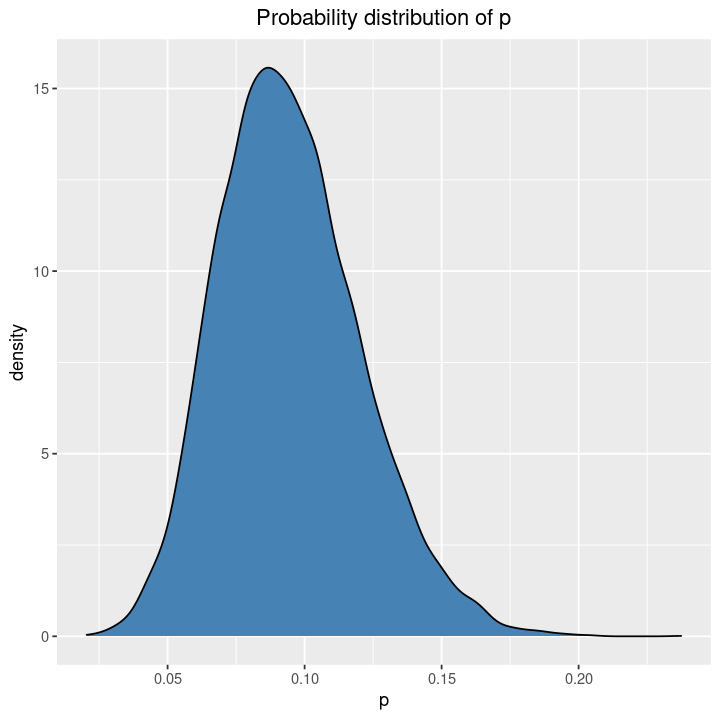

In [30]:

options(repr.plot.height=6, repr.plot.width=6)
ggplot(chain.df, aes(x=p)) +
geom_density(fill='steelblue') +
labs(title='Probability distribution of p', x='p') +
theme(plot.title=element_text(hjust=0.5))

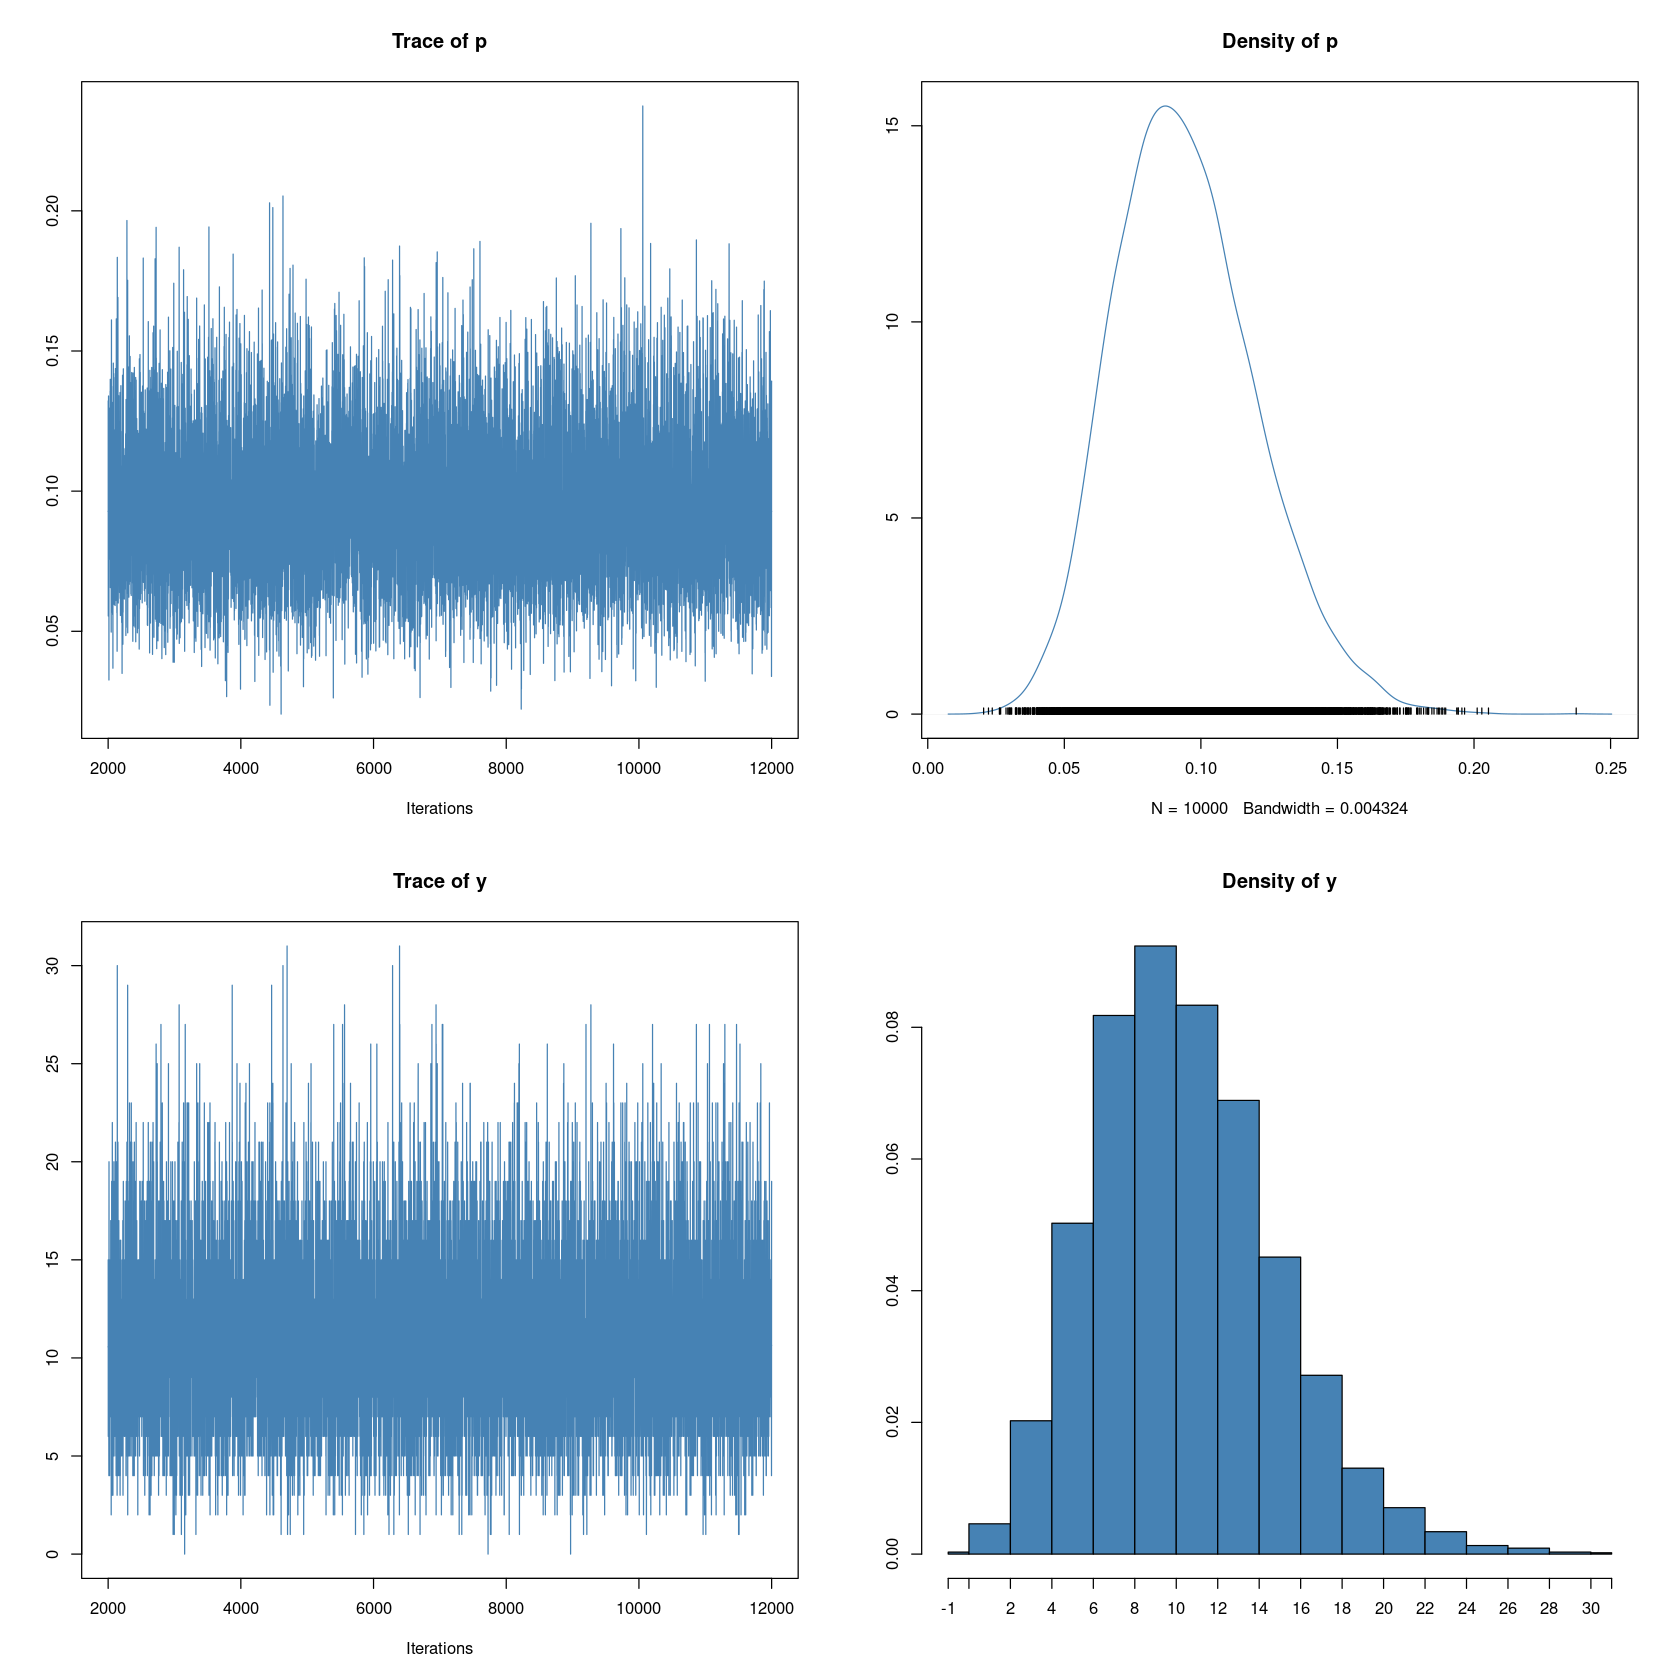

In [31]:
options(repr.plot.height=14, repr.plot.width=14)
plot(chain, col='steelblue')